In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pickle
import sklearn.model_selection as skmos

In [2]:
%%time
# hdu = fits.open('bp_rp_apogee.fits')
hdu = fits.open('bp_rp_lamost.fits')
# data = hdu[1].data

CPU times: user 2.96 ms, sys: 5.94 ms, total: 8.9 ms
Wall time: 5.87 ms


In [3]:
data = hdu[1].data

In [4]:
len(data['feh'])

5283562

In [5]:
len(data.names)

228

In [6]:
print('Creating vectors...')
# VEC = np.array(
#     [(data['bp_%d' % i] / 10**(8.5 - data['gaiaedr3_phot_g_mean_mag'] / 2.5))
#      for i in range(1, 56)] +
#     [(data['rp_%d' % i] / 10**(8.5 - data['gaiaedr3_phot_g_mean_mag'] / 2.5))
#      for i in range(1, 56)])
VEC = np.array(
    [(data['bp_%d' % i] / 10**(8.5 - data['phot_g_mean_mag'] / 2.5))
     for i in range(1, 56)] +
    [(data['rp_%d' % i] / 10**(8.5 - data['phot_g_mean_mag'] / 2.5))
     for i in range(1, 56)])
# EVEC = np.array(
#     [(data['bpe_%d' % i] / 10**(8.5 - data['gaiaedr3_phot_g_mean_mag'] / 2.5))
#      for i in range(1, 56)] +
#     [(data['rpe_%d' % i] / 10**(8.5 - data['gaiaedr3_phot_g_mean_mag'] / 2.5))
#      for i in range(1, 56)])
EVEC = np.array(
    [(data['bpe_%d' % i] / 10**(8.5 - data['phot_g_mean_mag'] / 2.5))
     for i in range(1, 56)] +
    [(data['rpe_%d' % i] / 10**(8.5 - data['phot_g_mean_mag'] / 2.5))
     for i in range(1, 56)])
print('VEC & EVEC made.')

Creating vectors...
VEC & EVEC made.


In [7]:
dataind = (data['ebv'] < .1) & (data['feh'] > -5)
dataind.sum()
np.random.seed(3232)

In [8]:
# if True:
#     # dataind = (data['sfd_ebv'] < .1) & (data['fe_h'] > -5)
#     dataind = (data['ebv'] < .1) & (data['feh'] > -5)
#     dataind.sum()
#     rstate = np.random.RandomState(3232)
#     rfc = RandomForestRegressor(n_jobs=-1,
#                                 random_state=rstate,verbose=1)
#     print('Fitting the regressor...')
#     rfc.fit(VEC[:, dataind].T, data['feh'][dataind])
#     print('Dumping the pickle...')
#     with open('rfr_lamost.pkl', 'wb') as fp:
#         pickle.dump(rfc, fp)
#     print('X-validating...')
#     fehpred = skmos.cross_val_predict(rfc, VEC[:, dataind].T, data['fe_h'][dataind])
#     print('Plotting...')
#     # plt.hist2d(data['fe_h'][dataind],
#     #          fehpred,
#     #          -4,
#     #          1,
#     #          -4,
#     #          1,
#     #          vmaxfrac=.99,
#     #          xtitle='feh apo',
#     #          ytitle='bprp/feh',
#     #          normx='sum')
#     plt.scatter(data['fe_h'][dataind],
#                 fehpred,
#                 # -4,
#                 # 1,
#                 # -4,
#                 # 1,
#                 # vmaxfrac=.99,
#                 # xtitle='feh apo',
#                 # ytitle='bprp/feh',
#                 # normx='sum'
#                 )
#     plt.xlabel('LAMOST Fe/H')
#     plt.ylabel('BP-RP FeH')
#     plt.xlim(-4,1)
#     plt.ylim(-4,1)
#     plt.plot([-3.85,.85],[-3.85,.85])
#     plt.tight_layout()
#     plt.savefig('feh_compar_lamost.pdf')

In [9]:
# plt.scatter(data['fe_h'][dataind],
#          fehpred,
#          # -4,
#          # 1,
#          # -4,
#          # 1,
#          # vmaxfrac=.99,
#          # xtitle='feh apo',
#          # ytitle='bprp/feh',
#          # normx='sum'
#          )
# plt.xlabel('APOGEE Fe/H')
# plt.ylabel('BP-RP FeH')
# plt.xlim(-4,1)
# plt.ylim(-4,1)
# plt.plot([-3.85,.85],[-3.85,.85])
# plt.tight_layout()
# plt.savefig('feh_compar.pdf')

In [1]:
from prfr import ProbabilisticRandomForestRegressor, split_arrays

In [11]:
x_obs = VEC[:, dataind].T
x_err = EVEC[:, dataind].T
y_obs = data['feh'][dataind]
y_obs.shape

(3288880,)

In [12]:
subsetidx = np.random.choice(len(x_obs[:]), size=100000, replace=False)
sub_x_obs = x_obs[subsetidx][:]
sub_x_err = x_err[subsetidx][:]
sub_y_obs = y_obs[subsetidx]
sub_y_obs.shape

(100000,)

In [13]:
print('train/dev/test...')
# train_arrays, test_arrays, valid_arrays = split_arrays(x_obs, x_err, y_obs, test_size=0.2, valid_size=0.2)
train_arrays, test_arrays, valid_arrays = split_arrays(sub_x_obs, sub_x_err, sub_y_obs, test_size=0.2, valid_size=0.2)
x_train, x_err_train, y_train = train_arrays
x_test, x_err_test, y_test = test_arrays
x_valid, x_err_valid, y_valid = valid_arrays

print('declaring model...')
model = ProbabilisticRandomForestRegressor(n_estimators=250, n_jobs=-1)
print('fitting model...')
model.fit(x_train, y_train, eX=x_err_train)
# print('calibrating model...')
# model.calibrate(x_valid, y_valid, eX=x_err_valid)
print('fitting the bias for the model...')
model.fit_bias(x_valid, y_valid, eX=x_err_valid)

print('dumping pickle...')
with open('prfr_lamost.pkl', 'wb') as fp:
    pickle.dump(model, fp)

print('predicting with the model...')
pred = model.predict(x_test, eX=x_err_test)
pred_bounds = np.quantile(pred, [0.16, 0.84], axis=1)
pred_mean = np.mean(pred, axis=1)

print(pred.shape)

train/dev/test...
declaring model...
fitting model...


  0%|          | 0/250 [00:00<?, ?it/s]

fitting the bias for the model...


  0%|          | 0/250 [00:00<?, ?it/s]

dumping pickle...
predicting with the model...


  0%|          | 0/250 [00:00<?, ?it/s]

(20000, 250)


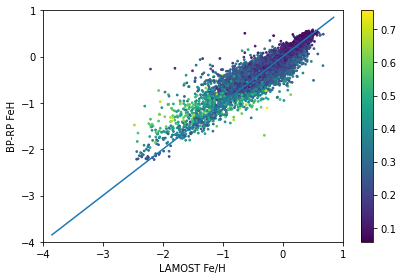

In [28]:
cm = np.array([abs(predb[1] - predb[0])/2 for predb in pred_bounds.T])
# plt.scatter(y_test[cm<.1],pred_mean[cm<.1],s=3,c = cm[cm<.1])
plt.scatter(y_test,pred_mean,s=3,c = cm)
# plt.text(-3.8,0.5,'avg +/-: '+str(np.round(np.average(cm),2))+' dex')
# print(np.average(cm))
plt.colorbar()
plt.xlabel('LAMOST Fe/H')
plt.ylabel('BP-RP FeH')
plt.xlim(-4,1)
plt.ylim(-4,1)
plt.plot([-3.85,.85],[-3.85,.85])
plt.tight_layout()
plt.savefig('feh_compar_lamost_prob.pdf')

In [15]:
# plt.errorbar(y_test,pred_mean,fmt='.')
# plt.xlabel('LAMOST Fe/H')
# plt.ylabel('BP-RP FeH')
# plt.xlim(-4,1)
# plt.ylim(-4,1)
# plt.plot([-3.85,.85],[-3.85,.85])
# plt.tight_layout()
# plt.savefig('feh_compar_lamost_prob.pdf')